In [12]:
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [7]:
image_folder = "WFLW_images"
selected_indices = list(range(60, 64)) + list(range(68, 72)) + [96, 97] # aici selectam indicii pt perechile de (x,y) de keypoints pt ochi
selected_indices_x = [i*2 for i in selected_indices]
selected_indices_y = [i*2+1 for i in selected_indices]
selected_indices = selected_indices_x + selected_indices_y
selected_indices.sort()
print(f"Selected keypoint indices: {selected_indices}") # print la toate perechile

train_keypoints_file = "list_98pt_rect_attr_train.txt"
test_keypoints_file = "list_98pt_rect_attr_test.txt"

columns = [
    f"x{i//2}" if i % 2 == 0 else f"y{i//2}" for i in range(196)
] + ["x_min_rect", "y_min_rect", "x_max_rect", "y_max_rect",
     "pose", "expression", "illumination", "make_up", "occlusion", "blur", "image_name"]

keypoints_train_df = pd.read_csv(train_keypoints_file, sep=r'\s+', names=columns)
keypoints_test_df = pd.read_csv(test_keypoints_file, sep=r'\s+', names=columns)

train_keypoints_df = keypoints_train_df.iloc[:, selected_indices].copy()  # adaugam mizeriile de x,y keypoints
train_keypoints_df['image_name'] = keypoints_train_df['image_name'].copy() # adaugam numele imaginii ca sa o putem cauta in folder

test_keypoints_df = keypoints_test_df.iloc[:, selected_indices].copy() 
test_keypoints_df['image_name'] = keypoints_test_df['image_name'].copy()


train_keypoints_df = train_keypoints_df[['image_name'] + [col for col in train_keypoints_df.columns if col != 'image_name']] # punem numele pe prima coloana sa fie standard
test_keypoints_df = test_keypoints_df[['image_name'] + [col for col in test_keypoints_df.columns if col != 'image_name']]

train_keypoints_df.to_csv('data/filtered_train_keypoints.csv', index=False) # facem csv-uri noi pe care le vom folosi pt a crea tensorii
test_keypoints_df.to_csv('data/filtered_test_keypoints.csv', index=False)

Selected keypoint indices: [120, 121, 122, 123, 124, 125, 126, 127, 136, 137, 138, 139, 140, 141, 142, 143, 192, 193, 194, 195]


In [8]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string) - dataframe-ul
            root_dir (string) - folder cu imagini
            transform (callable, optional) - vom folosi transform pt. normalizare etc (care dintr-un motiv sau altul cred ca nu merge)
        """
        self.keypoints_frame = pd.read_csv(csv_file)  
        self.root_dir = root_dir 
        self.transform = transform  

    def __len__(self):
        return len(self.keypoints_frame) 

    def __getitem__(self, idx):
        img_name = self.keypoints_frame.iloc[idx, 0]  # deci fiecare element o sa aiba nume
        img_path = os.path.join(self.root_dir, img_name)  
        image = Image.open(img_path)  

        keypoints = self.keypoints_frame.iloc[idx, 1:].values  # & coordonate pt ochi
        keypoints = keypoints.astype('float').reshape(-1, 2) 
  
        sample = {'image': image, 'keypoints': keypoints}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [24]:
train_kp = "data\\filtered_train_keypoints.csv"
test_kp = "data\\filtered_test_keypoints.csv" 

train_dataset = FacialKeypointsDataset(csv_file=train_kp,
                                        root_dir=image_folder)

test_dataset = FacialKeypointsDataset(csv_file=test_kp,
                                       root_dir=image_folder)

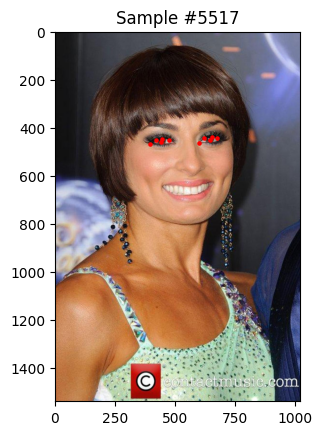

In [25]:
def show_sample(dataset):
    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]  
    image = np.array(sample['image'])  
    keypoints = sample['keypoints']  

    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
    plt.title(f"Sample #{idx}")
    plt.show()

show_sample(train_dataset)

In [48]:
data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),          
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ]
)


train_dataset_TR = FacialKeypointsDataset(csv_file=train_kp,
                                        root_dir=image_folder,
                                        transform=data_transform)

test_dataset_TR = FacialKeypointsDataset(csv_file=test_kp,
                                       root_dir=image_folder,
                                       transform=data_transform)

train_loader = DataLoader(train_dataset_TR, batch_size=16, shuffle=True) # astea-s generatoarele de pe tensorflow ish
test_loader = DataLoader(test_dataset_TR, batch_size=16, shuffle=False)

print(f'Numărul de imagini de antrenament: {len(train_dataset)}')
print(f'Numărul de imagini de test: {len(test_dataset)}')

for i, sample in enumerate(test_loader):
    if i == 0:
        print(f"Imagini (batch): {sample['image'].size()}")
        print(f"Keypoints (batch): {sample['keypoints'].size()}")

Numărul de imagini de antrenament: 7500
Numărul de imagini de test: 2500
Imagini (batch): torch.Size([16, 3, 224, 224])
Keypoints (batch): torch.Size([16, 10, 2])


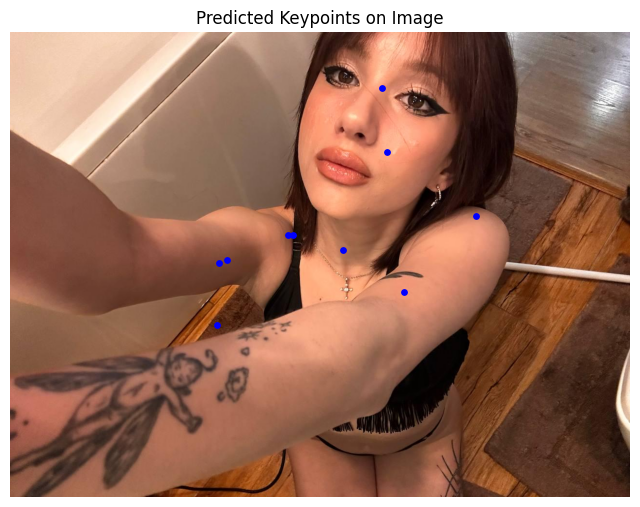

In [72]:
# Set number of keypoints
num_keypoints = 10

# Load ResNet18 pre-trained model
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_keypoints * 2)  # 10 keypoints * 2 coordinates each
resnet18.eval()

# Transformation for the input image
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'redline.jpg'
image = Image.open(image_path)
image_tensor = data_transform(image).unsqueeze(0)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():
    output_pts = resnet18(image_tensor)

# Reshape to get the coordinates
output_pts = output_pts.view(num_keypoints, 2).data.numpy()

mean = np.array([0.485, 0.456, 0.406]) 
std = np.array([0.229, 0.224, 0.225])   
output_pts[:, 0] = output_pts[:, 0] * std[0] + mean[0]  
output_pts[:, 1] = output_pts[:, 1] * std[1] + mean[1]  

image = np.array(image)  

# Display the image with keypoints
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

# Draw keypoints on the image
for (x, y) in output_pts:
    ax.scatter(x * image.shape[1], y * image.shape[0], c='b', s=15, marker='o')  # De-normalized coordinates

ax.set_title('Predicted Keypoints on Image')
plt.axis('off')
plt.show()